In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

# AAPL

In [2]:
data = pd.read_csv('/kaggle/input/apple-daily-dataset/AAPL_day_new_data.csv')
data.tail()

,Date,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
3792,2025-01-30,238.407871,240.525538,236.949483,237.329056,55658300,239.744405,236.706177,51.292711,-2.704714,-3.445377,251.151412,218.947722
3793,2025-01-31,246.918527,246.918527,233.183628,235.740814,101075100,239.964164,236.668320,49.385834,-2.320950,-3.220492,248.879821,219.778898
3794,2025-02-03,229.737419,231.575395,225.452122,227.759583,73063300,239.963964,236.318957,41.114113,-2.630510,-3.102495,247.705859,219.370598
3795,2025-02-04,227.000419,232.873966,226.401072,232.544327,45067300,240.054265,236.170933,46.860376,-2.461376,-2.974271,246.484818,219.536799
3796,2025-02-05,228.279016,232.414468,228.019307,232.214691,39620300,240.123589,236.015786,46.523548,-2.327110,-2.844839,244.739628,220.030366


In [3]:
def preprocessing(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    scaler = MinMaxScaler()

    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data

In [4]:
apple_stock = preprocessing(data)
apple_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3797 entries, 2010-01-04 to 2025-02-05
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3797 non-null   float64
 1   High         3797 non-null   float64
 2   Low          3797 non-null   float64
 3   Close        3797 non-null   float64
 4   Volume       3797 non-null   float64
 5   SMA          3797 non-null   float64
 6   EMA          3797 non-null   float64
 7   RSI          3797 non-null   float64
 8   MACD         3797 non-null   float64
 9   MACD_Signal  3797 non-null   float64
 10  BB_Upper     3797 non-null   float64
 11  BB_Lower     3797 non-null   float64
dtypes: float64(12)
memory usage: 385.6 KB


<ipython-input-3-80cb02926627>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-80cb02926627>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [5]:
columns = ['Open', 'Low', 'High', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower' ]

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            dropout=dropout if num_layers > 1 else 0,
                            batch_first=True, bidirectional=False)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        device = x.device

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        
        out = out.transpose(1, 2)              
        out = self.batch_norm(out)             
        out = out.transpose(1, 2)              

        out = self.dropout(out)
        out = self.fc(out[:, -1, :])       
        return out

In [7]:
def create_sequences(data, targets, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  
        label = targets[i + sequence_length] 
        sequences.append(seq)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    # sequences = np.transpose(sequences, (0, 2, 1))  
    return sequences, labels

In [8]:
def prepare_dataloaders(data, feature_columns, target_column, sequence_length, batch_size, test_size=0.1):
    X = data[feature_columns].values
    y = data[target_column].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=test_size, shuffle=False)
    
    x_train, y_train = create_sequences(X_train, Y_train, sequence_length)
    x_val, y_val = create_sequences(X_val, Y_val, sequence_length)
    x_test, y_test = create_sequences(X_test, Y_test, sequence_length)
    
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader, y_test

In [9]:
def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            all_targets.append(targets.cpu().detach().numpy())
            all_outputs.append(outputs.cpu().detach().numpy())
            
    avg_loss = total_loss / len(dataloader.dataset)
    targets = np.concatenate(all_targets)
    outputs = np.concatenate(all_outputs)
    
    mse = np.mean((outputs - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(outputs - targets))
    
    return avg_loss, rmse, mae

In [10]:
def plot_metrics(predictions, targets, name):
    
    predictions_natural = predictions.flatten()
    targets_natural = targets.flatten() 

    plt.figure(figsize=(10, 6))
    plt.plot(targets_natural, label="Real Values", color='blue')
    plt.plot(predictions_natural, label="Predicted Values", color='red', linestyle='dashed')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Real vs Predicted Values')
    plt.legend()
    plt.savefig(name, dpi=99, bbox_inches='tight')
    plt.show()

In [11]:
def evaluate_on_test(model, test_dataloader, criterion, device):
    model.eval()  
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            loss = criterion(outputs, targets)  
            test_loss += loss.item() * inputs.size(0) 
            
            pred_np = outputs.cpu().numpy()
            target_np = targets.cpu().numpy()
            
            if np.ndim(pred_np) == 0:
                pred_np = np.array([pred_np])
            if np.ndim(target_np) == 0:
                target_np = np.array([target_np])
            
            all_predictions.append(outputs.cpu().numpy())  
            all_targets.append(targets.cpu().numpy())
    
    test_loss /= len(test_dataloader.dataset)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    
    return all_predictions, all_targets

In [12]:
def train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, name_model=""):
    model.to(device)
    best_val_loss = float('inf')
    
    train_rmse_list, train_mae_list = [], []
    val_rmse_list, val_mae_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(num_epochs):
        model.train()
        all_train_targets = []
        all_train_outputs = []
        batch_inputs, batch_targets = [], []

        for inputs, targets in train_dataloader:
            batch_inputs.append(inputs.to(device))
            batch_targets.append(targets.float().to(device))
        
        inputs = torch.cat(batch_inputs)
        targets = torch.cat(batch_targets)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        outputs = outputs.view_as(targets)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss = loss.item() * inputs.size(0)
        all_train_targets.append(targets.cpu().detach().numpy())
        all_train_outputs.append(outputs.cpu().detach().numpy())

        train_targets = np.concatenate(all_train_targets)
        train_outputs = np.concatenate(all_train_outputs)

        train_mse = np.mean((train_outputs - train_targets) ** 2)
        train_rmse = np.sqrt(train_mse)
        train_mae = np.mean(np.abs(train_outputs - train_targets))

        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
        train_loss_list.append(train_loss / len(train_dataloader.dataset))

        val_loss, val_rmse, val_mae = evaluate_model(model, val_dataloader, criterion, device)
        val_rmse_list.append(val_rmse)
        val_mae_list.append(val_mae)
        val_loss_list.append(val_loss)

        if val_loss < best_val_loss and name_model != '':
            best_val_loss = val_loss
            torch.save(model.state_dict(), name_model)

        if ((epoch + 1) % 100) == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
            print(f'Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')

    if name_model != '':
        torch.save(model.state_dict(), name_model)

    return train_loss_list, val_loss_list

In [13]:
def evaluate_and_plot(test_dataloader, model, criterion, device, png, train_loss_list, val_loss_list, num_epochs):
    model.to(device)

    test_loss, test_rmse, test_mae = evaluate_model(model, test_dataloader, criterion, device)
    predictions, targets = evaluate_on_test(model, test_dataloader, criterion, device)

    print('\nFinal Results:')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')

    plot_metrics(predictions, targets, png)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [14]:
def seed_everything(seed_value=0):
    random.seed(seed_value)  
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value) 
    torch.cuda.manual_seed(seed_value) 
    torch.cuda.manual_seed_all(seed_value) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

## Lr

In [15]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2858, Train MAE: 0.2041
Val RMSE: 0.0858, Val MAE: 0.0716


In [16]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.00001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.3523, Train MAE: 0.2538
Val RMSE: 0.0967, Val MAE: 0.0832


## DROPOUT

In [17]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2242, Train MAE: 0.1574
Val RMSE: 0.0675, Val MAE: 0.0576


In [18]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.1
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.1570, Train MAE: 0.1100
Val RMSE: 0.0672, Val MAE: 0.0574


## NUM LAYERS

In [19]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 2 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.3002, Train MAE: 0.2359
Val RMSE: 0.1688, Val MAE: 0.1662


In [20]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 3 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2247, Train MAE: 0.1807
Val RMSE: 0.0888, Val MAE: 0.0842


## HIDDEN SIZE

In [21]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 256
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.3242, Train MAE: 0.2345
Val RMSE: 0.0964, Val MAE: 0.0901


In [22]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 512
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2662, Train MAE: 0.1929
Val RMSE: 0.1382, Val MAE: 0.1256


## NUM EPOCHES

In [23]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/200:
Train RMSE: 0.2858, Train MAE: 0.2041
Val RMSE: 0.0858, Val MAE: 0.0716
Epoch 200/200:
Train RMSE: 0.2264, Train MAE: 0.1664
Val RMSE: 0.0521, Val MAE: 0.0438


In [24]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 300

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/300:
Train RMSE: 0.2858, Train MAE: 0.2041
Val RMSE: 0.0858, Val MAE: 0.0716
Epoch 200/300:
Train RMSE: 0.2264, Train MAE: 0.1664
Val RMSE: 0.0521, Val MAE: 0.0438
Epoch 300/300:
Train RMSE: 0.1897, Train MAE: 0.1374
Val RMSE: 0.0476, Val MAE: 0.0386


## Test timestep 5

Epoch 100/200:
Train RMSE: 0.2897, Train MAE: 0.2157
Val RMSE: 0.0463, Val MAE: 0.0395
Epoch 200/200:
Train RMSE: 0.2549, Train MAE: 0.1898
Val RMSE: 0.0896, Val MAE: 0.0852

Final Results:
Test RMSE: 0.1052
Test MAE: 0.0933


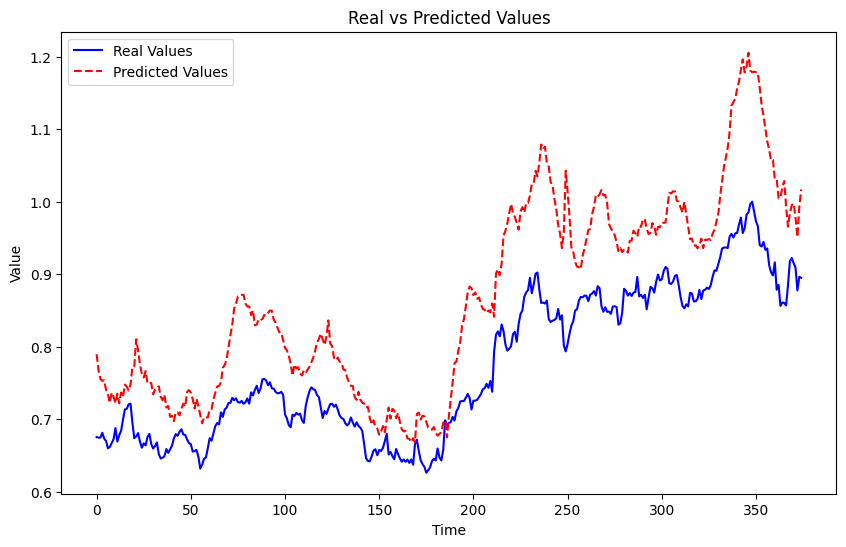

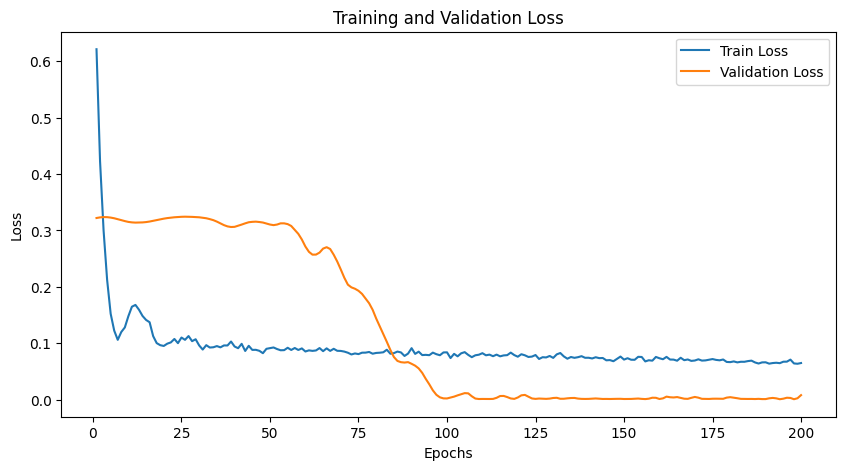

In [25]:
seed_everything(0)
sequence_length = 5    
input_size = 11
hidden_size = 256
num_layers = 1 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'lstm_model_apple_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_5_lstm.png', train_losses, val_losses, num_epochs)

## Test timestep 10

Epoch 100/200:
Train RMSE: 0.2562, Train MAE: 0.1845
Val RMSE: 0.0868, Val MAE: 0.0797
Epoch 200/200:
Train RMSE: 0.2285, Train MAE: 0.1676
Val RMSE: 0.0305, Val MAE: 0.0248

Final Results:
Test RMSE: 0.0380
Test MAE: 0.0326


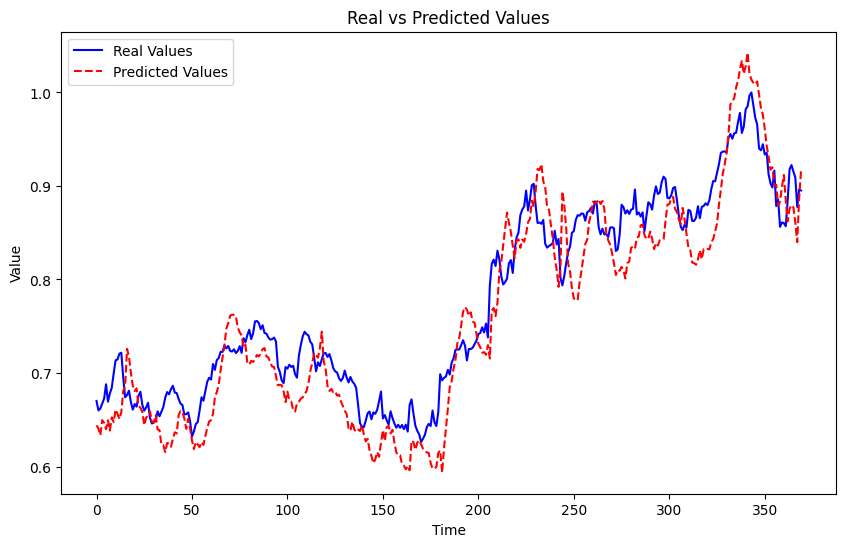

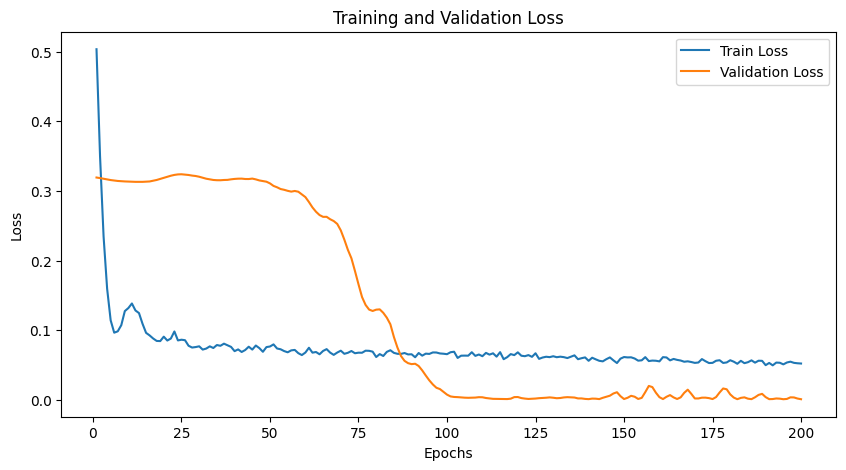

In [26]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 256
num_layers = 1 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'lstm_model_apple_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_10_lstm.png', train_losses, val_losses, num_epochs)

## Test timestep 20

Epoch 100/200:
Train RMSE: 0.2428, Train MAE: 0.1700
Val RMSE: 0.1251, Val MAE: 0.1190
Epoch 200/200:
Train RMSE: 0.2110, Train MAE: 0.1544
Val RMSE: 0.0572, Val MAE: 0.0493

Final Results:
Test RMSE: 0.0555
Test MAE: 0.0456


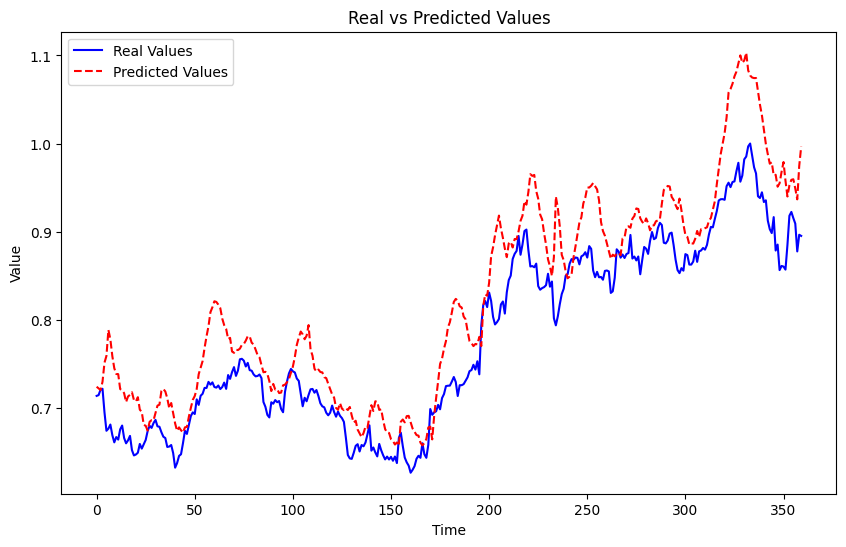

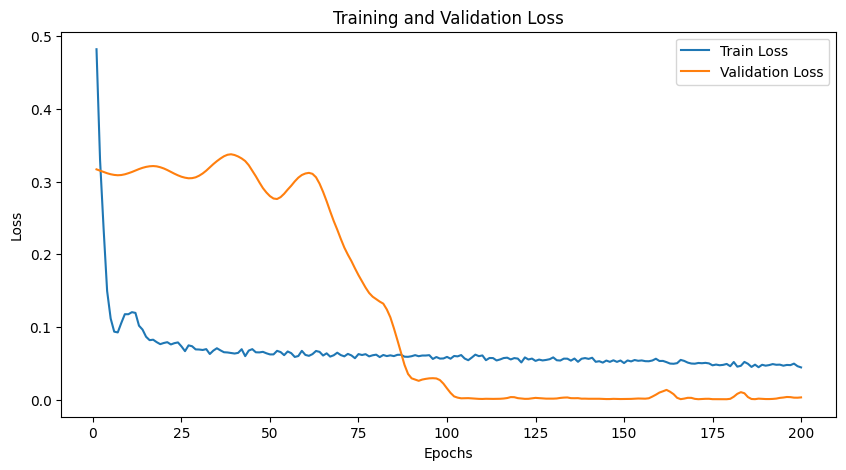

In [27]:
seed_everything(0)
sequence_length = 20    
input_size = 11
hidden_size = 256
num_layers = 1 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'lstm_model_apple_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_20_lstm.png', train_losses, val_losses, num_epochs)

# META

In [28]:
data = pd.read_csv('/kaggle/input/meta-dataset/META_day.csv')
meta_stock = preprocessing(data)
meta_stock.tail()

<ipython-input-3-80cb02926627>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-80cb02926627>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
Date,,,,,,,,,,,,
2025-04-28,0.749487,0.748276,0.739388,0.740697,0.018375,0.906076,0.871400,0.441323,0.209590,0.057638,0.775363,0.712104
2025-04-29,0.736048,0.745617,0.744377,0.747239,0.012497,0.900351,0.870095,0.457564,0.262783,0.092388,0.770651,0.714116
2025-04-30,0.725454,0.735272,0.723713,0.739667,0.043101,0.895094,0.868506,0.437595,0.300065,0.128458,0.761696,0.718664
2025-05-01,0.800285,0.796000,0.781663,0.771976,0.046372,0.890966,0.868410,0.518210,0.362421,0.171143,0.758003,0.721092
2025-05-02,0.788261,0.805667,0.792730,0.805371,0.012139,0.887875,0.869796,0.588880,0.444745,0.223551,0.772604,0.714337


## LEARNING RATE 

In [29]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2676, Train MAE: 0.2025
Val RMSE: 0.0430, Val MAE: 0.0302


In [30]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.00001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.3265, Train MAE: 0.2487
Val RMSE: 0.0834, Val MAE: 0.0587


## DropOut

In [31]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2208, Train MAE: 0.1648
Val RMSE: 0.0479, Val MAE: 0.0339


In [32]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.1
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.1544, Train MAE: 0.1156
Val RMSE: 0.0493, Val MAE: 0.0345


## Number layers

In [33]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 2 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2873, Train MAE: 0.2283
Val RMSE: 0.0807, Val MAE: 0.0758


In [34]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 3 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2088, Train MAE: 0.1673
Val RMSE: 0.0592, Val MAE: 0.0508


## Hidden size

In [35]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 256
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2985, Train MAE: 0.2249
Val RMSE: 0.0590, Val MAE: 0.0488


In [36]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 512
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2453, Train MAE: 0.1837
Val RMSE: 0.1259, Val MAE: 0.1073


## Num epoches

In [37]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/200:
Train RMSE: 0.2676, Train MAE: 0.2025
Val RMSE: 0.0430, Val MAE: 0.0302
Epoch 200/200:
Train RMSE: 0.2323, Train MAE: 0.1737
Val RMSE: 0.0427, Val MAE: 0.0314


In [38]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 300

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/300:
Train RMSE: 0.2676, Train MAE: 0.2025
Val RMSE: 0.0430, Val MAE: 0.0302
Epoch 200/300:
Train RMSE: 0.2323, Train MAE: 0.1737
Val RMSE: 0.0427, Val MAE: 0.0314
Epoch 300/300:
Train RMSE: 0.1889, Train MAE: 0.1427
Val RMSE: 0.0231, Val MAE: 0.0174


## Timestep = 5

Epoch 100/300:
Train RMSE: 0.2602, Train MAE: 0.1971
Val RMSE: 0.0519, Val MAE: 0.0387
Epoch 200/300:
Train RMSE: 0.2290, Train MAE: 0.1750
Val RMSE: 0.0476, Val MAE: 0.0337
Epoch 300/300:
Train RMSE: 0.2093, Train MAE: 0.1577
Val RMSE: 0.0402, Val MAE: 0.0322

Final Results:
Test RMSE: 0.0635
Test MAE: 0.0521


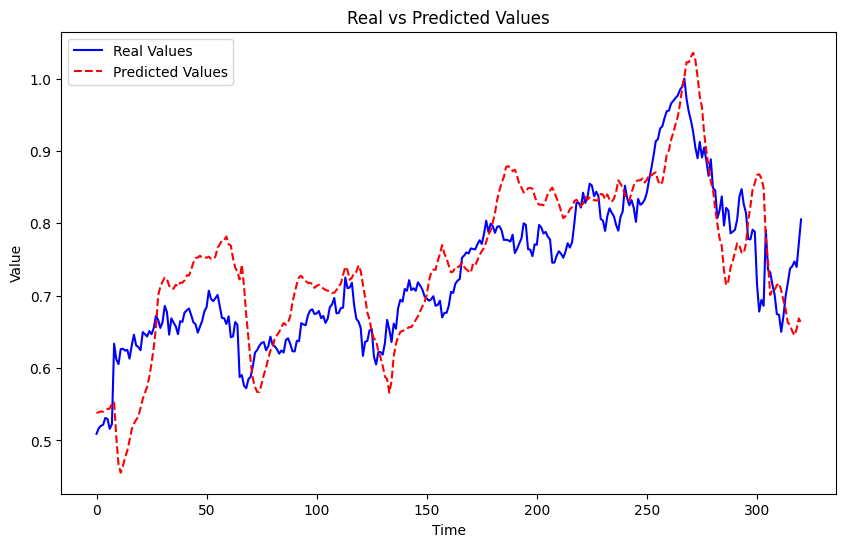

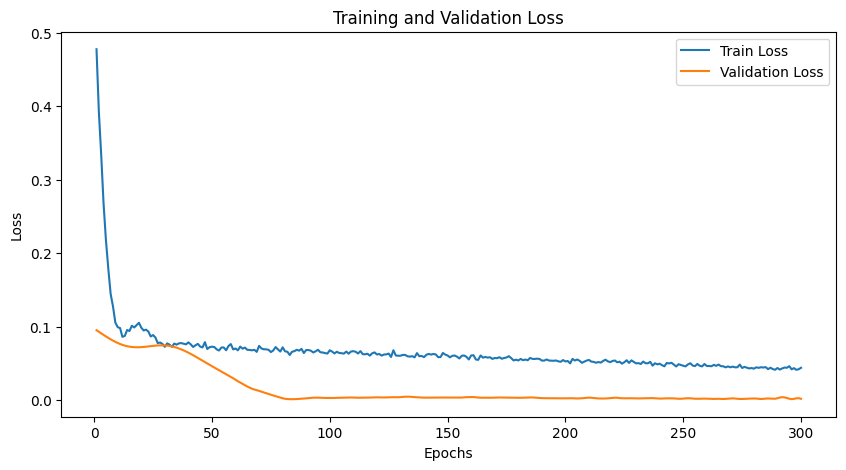

In [39]:
seed_everything(0)
sequence_length = 5    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 300

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'lstm_model_meta_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_5_lstm.png', train_losses, val_losses, num_epochs)

## Timestep = 10

Epoch 100/300:
Train RMSE: 0.2208, Train MAE: 0.1648
Val RMSE: 0.0479, Val MAE: 0.0339
Epoch 200/300:
Train RMSE: 0.1947, Train MAE: 0.1454
Val RMSE: 0.0588, Val MAE: 0.0500
Epoch 300/300:
Train RMSE: 0.1635, Train MAE: 0.1219
Val RMSE: 0.0260, Val MAE: 0.0213

Final Results:
Test RMSE: 0.0513
Test MAE: 0.0395


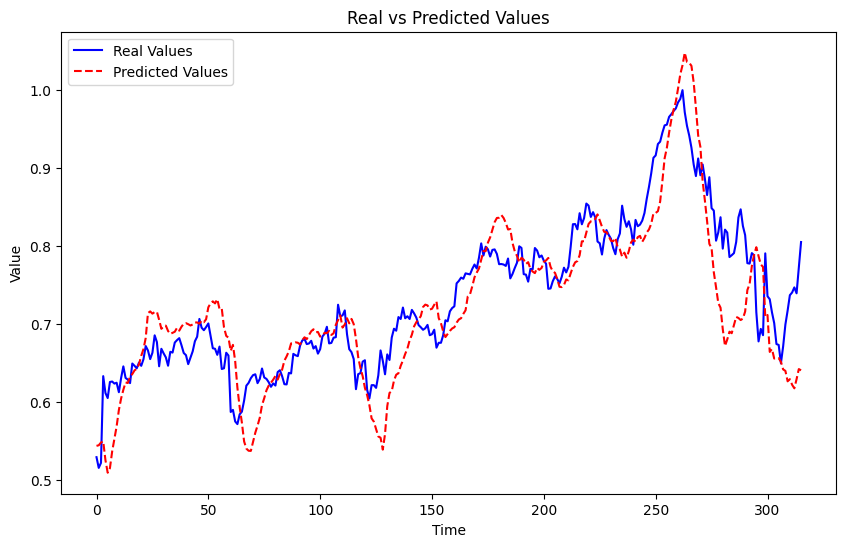

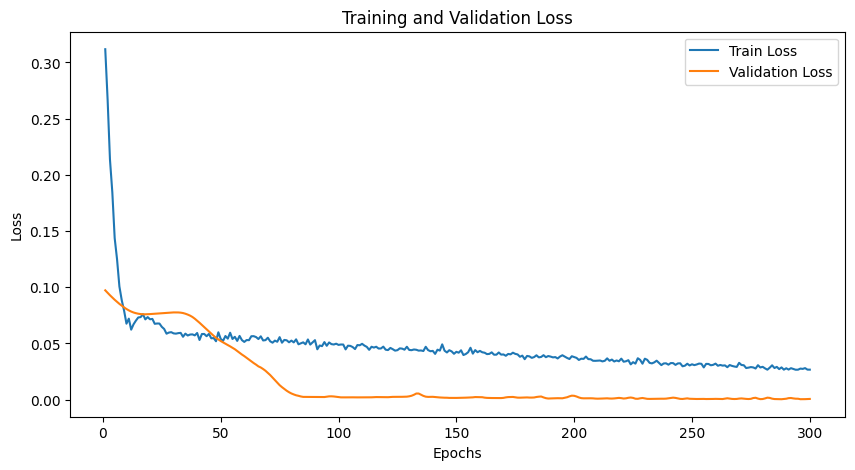

In [40]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 300

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'lstm_model_meta_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_10_lstm.png', train_losses, val_losses, num_epochs)

## Timestep = 20

Epoch 100/300:
Train RMSE: 0.1953, Train MAE: 0.1421
Val RMSE: 0.0375, Val MAE: 0.0267
Epoch 200/300:
Train RMSE: 0.1579, Train MAE: 0.1171
Val RMSE: 0.0251, Val MAE: 0.0193
Epoch 300/300:
Train RMSE: 0.1284, Train MAE: 0.0959
Val RMSE: 0.0354, Val MAE: 0.0322

Final Results:
Test RMSE: 0.0568
Test MAE: 0.0444


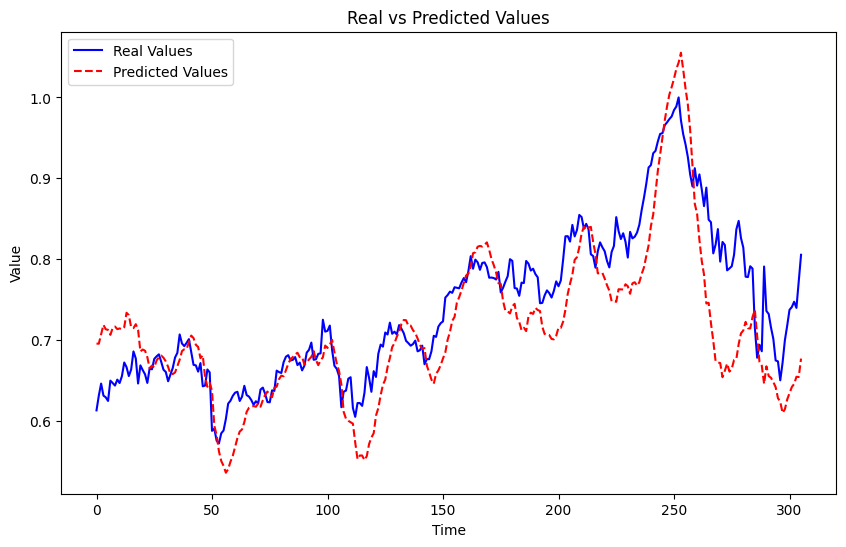

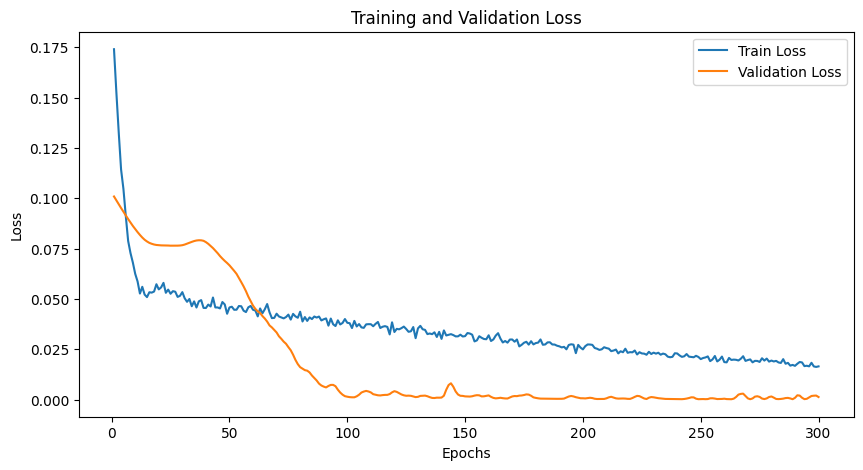

In [41]:
seed_everything(0)
sequence_length = 20   
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 300

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'lstm_model_meta_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_20_lstm.png', train_losses, val_losses, num_epochs)

# TESLA 

In [42]:
data = pd.read_csv('/kaggle/input/tesla-dataset/Tesla_day.csv')
tesla_stock = preprocessing(data)
tesla_stock.tail()

<ipython-input-3-80cb02926627>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-80cb02926627>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
Date,,,,,,,,,,,,
2025-04-28,0.606338,0.602652,0.594556,0.594868,0.164369,0.668509,0.714936,0.538552,0.452898,0.377682,0.586609,0.570638
2025-04-29,0.599009,0.599492,0.609999,0.607712,0.117427,0.665325,0.716542,0.559510,0.488656,0.403206,0.597159,0.565613
2025-04-30,0.587215,0.581295,0.590963,0.587099,0.139409,0.661734,0.717078,0.510602,0.506086,0.427586,0.601176,0.564011
2025-05-01,0.587447,0.594466,0.610743,0.583673,0.107290,0.657739,0.717427,0.502496,0.517583,0.449703,0.600390,0.564440
2025-05-02,0.597746,0.602488,0.610743,0.597646,0.123125,0.654385,0.718443,0.529324,0.533031,0.470906,0.606345,0.561966


## Learning rate

In [43]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2976, Train MAE: 0.1984
Val RMSE: 0.1223, Val MAE: 0.0983


In [44]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.00001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.3720, Train MAE: 0.2481
Val RMSE: 0.1454, Val MAE: 0.1122


## dropout

In [45]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2286, Train MAE: 0.1517
Val RMSE: 0.0985, Val MAE: 0.0747


In [46]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.1
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.1617, Train MAE: 0.1060
Val RMSE: 0.0930, Val MAE: 0.0707


## number layers

In [47]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 2 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2918, Train MAE: 0.2250
Val RMSE: 0.1045, Val MAE: 0.0970


In [48]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 3 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2373, Train MAE: 0.1897
Val RMSE: 0.0834, Val MAE: 0.0727


## hidden size

In [49]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 256
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.3112, Train MAE: 0.2190
Val RMSE: 0.1256, Val MAE: 0.1143


In [50]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 512
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2715, Train MAE: 0.1840
Val RMSE: 0.1563, Val MAE: 0.1445


## num epoches

In [51]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/200:
Train RMSE: 0.2976, Train MAE: 0.1984
Val RMSE: 0.1223, Val MAE: 0.0983
Epoch 200/200:
Train RMSE: 0.2244, Train MAE: 0.1560
Val RMSE: 0.0500, Val MAE: 0.0411


In [52]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 1 
dropout = 0.3
batch_size = 64
learning_rate = 0.0001
num_epochs = 300

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/300:
Train RMSE: 0.2976, Train MAE: 0.1984
Val RMSE: 0.1223, Val MAE: 0.0983
Epoch 200/300:
Train RMSE: 0.2244, Train MAE: 0.1560
Val RMSE: 0.0500, Val MAE: 0.0411
Epoch 300/300:
Train RMSE: 0.1827, Train MAE: 0.1279
Val RMSE: 0.0482, Val MAE: 0.0403


## timestep = 5

Epoch 100/200:
Train RMSE: 0.2574, Train MAE: 0.1985
Val RMSE: 0.1751, Val MAE: 0.1705
Epoch 200/200:
Train RMSE: 0.2028, Train MAE: 0.1576
Val RMSE: 0.0366, Val MAE: 0.0300

Final Results:
Test RMSE: 0.0523
Test MAE: 0.0396


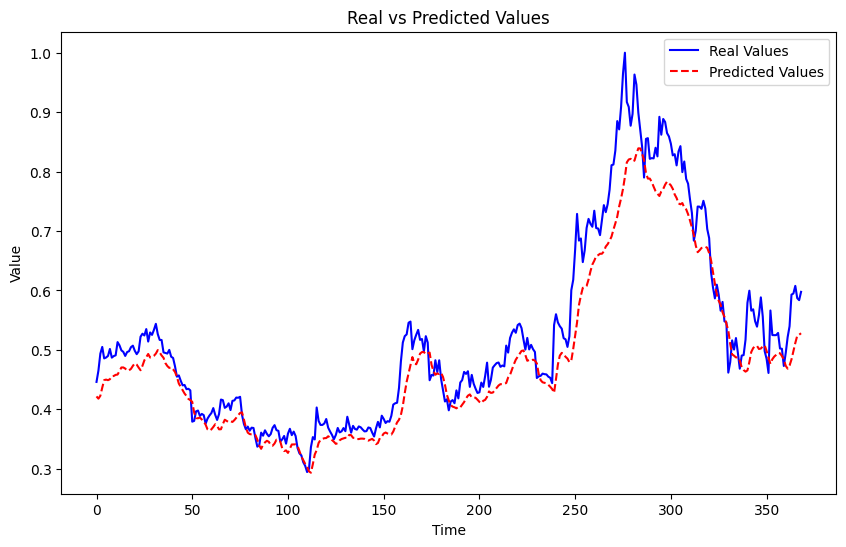

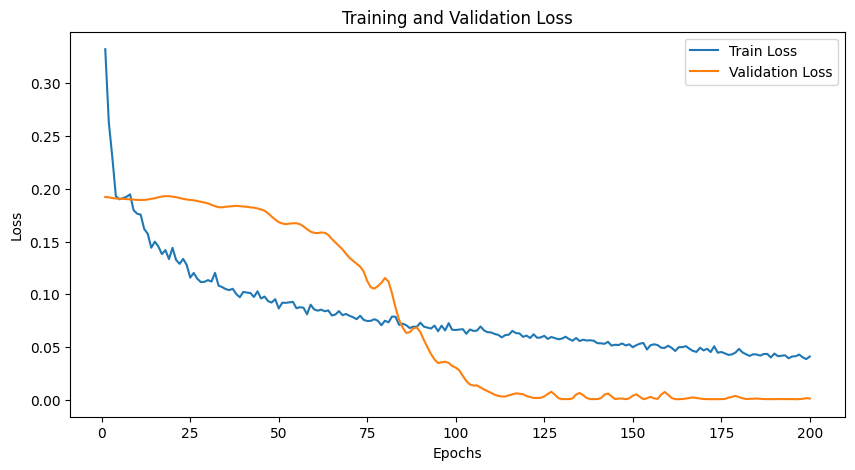

In [53]:
seed_everything(0)
sequence_length = 5    
input_size = 11
hidden_size = 128
num_layers = 2 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'model_lstm_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_lstm_step_5.png', train_losses, val_losses, num_epochs)

## timestep = 10

Epoch 100/200:
Train RMSE: 0.2333, Train MAE: 0.1853
Val RMSE: 0.0991, Val MAE: 0.0947
Epoch 200/200:
Train RMSE: 0.1884, Train MAE: 0.1499
Val RMSE: 0.0212, Val MAE: 0.0182

Final Results:
Test RMSE: 0.0622
Test MAE: 0.0528


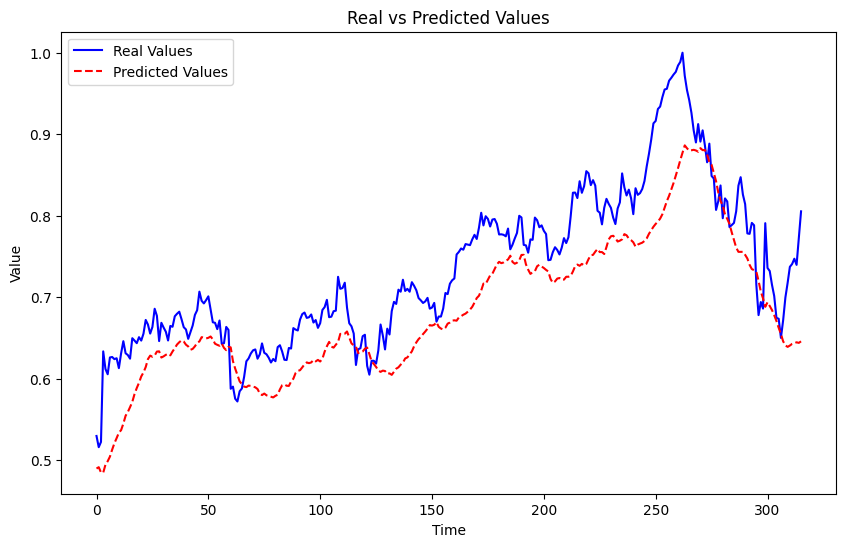

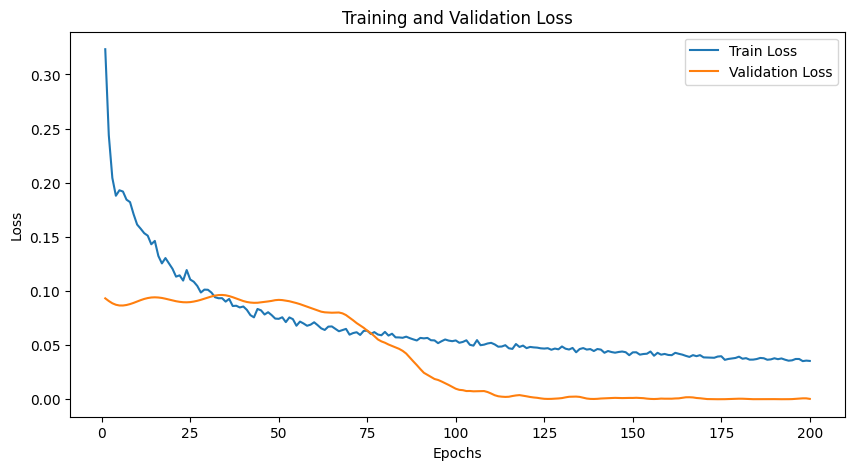

In [55]:
seed_everything(0)
sequence_length = 10    
input_size = 11
hidden_size = 128
num_layers = 2 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'tesla_model_lstm_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_10_lstm.png', train_losses, val_losses, num_epochs)

## timestep = 20

Epoch 100/200:
Train RMSE: 0.2122, Train MAE: 0.1597
Val RMSE: 0.0813, Val MAE: 0.0724
Epoch 200/200:
Train RMSE: 0.1719, Train MAE: 0.1330
Val RMSE: 0.0295, Val MAE: 0.0236

Final Results:
Test RMSE: 0.0421
Test MAE: 0.0295


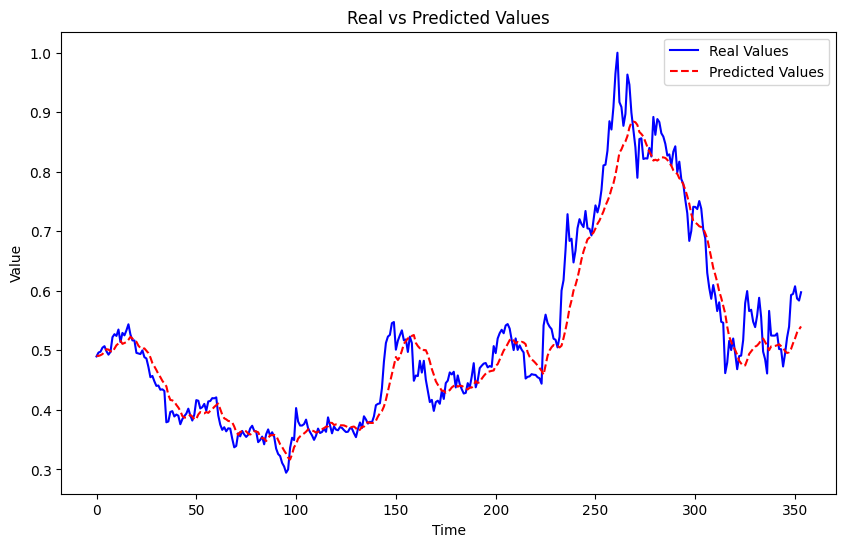

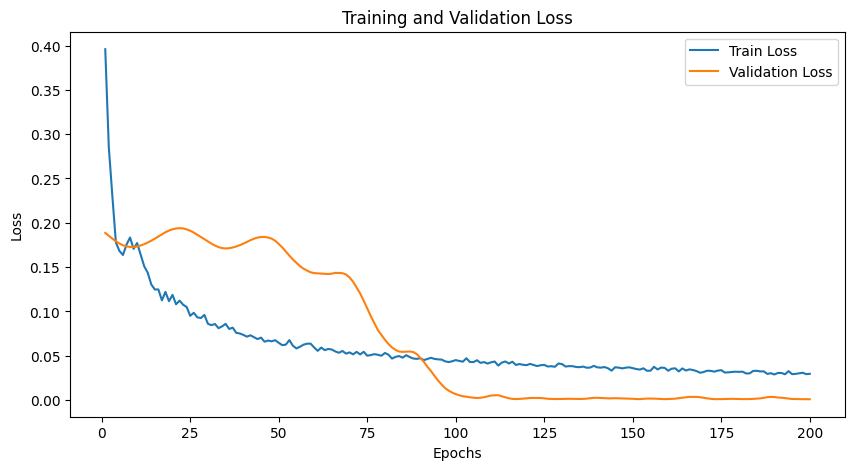

In [56]:
seed_everything(0)
sequence_length = 20    
input_size = 11
hidden_size = 128
num_layers = 2 
dropout = 0.2
batch_size = 64
learning_rate = 0.0001
num_epochs = 200

model = LSTM(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', sequence_length, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'tesla_lstm_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_20_lstm.png', train_losses, val_losses, num_epochs)